In [1]:
!make -C .. statpop scenario_prop scenario_endpoints

make: Entering directory '/home/martibosch/data-science/lausanne-greening-scenarios'
make: Nothing to be done for 'statpop'.
make: Nothing to be done for 'scenario_prop'.
make: Nothing to be done for 'scenario_endpoints'.
make: Leaving directory '/home/martibosch/data-science/lausanne-greening-scenarios'


In [2]:
import tempfile
from os import path

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import salem
import seaborn as sns
import swiss_uhi_utils as suhi
import swisslandstats as sls
import xarray as xr
from affine import Affine

In [3]:
agglom_extent_filepath = '../data/raw/agglom-extent/agglom-extent.shp'
statpop_filepath = '../data/raw/statpop/statpop-2019.csv'

scenario_prop_filepath = '../data/processed/scenario-prop.nc'
scenario_endpoints_filepath = '../data/processed/scenario-endpoints.nc'
# t_da_filepath = '../data/processed/tair-ucm.nc'

In [4]:
def da_from_column(ldf, column):
    with tempfile.TemporaryDirectory() as tmp_dir:
        tmp_filepath = path.join(tmp_dir, f'{column}.tif')
        ldf.to_geotiff(tmp_filepath, column)
        # ldf = ldf.drop(column, axis=1)
        da =  salem.open_xr_dataset(tmp_filepath)['data']
    da.name = column
    return da

In [5]:
agglom_extent_gdf = gpd.read_file(agglom_extent_filepath)
ldf = sls.read_csv(statpop_filepath, x_column='E_KOORD', y_column='N_KOORD')
agglom_ldf = ldf.clip_by_geometry(
    geometry=agglom_extent_gdf.iloc[0]['geometry'],
    geometry_crs=agglom_extent_gdf.crs)
pop_columns = ['elder', 'total']
agglom_ldf['elder'] = agglom_ldf[[
    f'B19B{sex}{age_group:02}' for sex in ['M', 'W']
    for age_group in range(13, 20)
]].sum(axis=1)
agglom_ldf['total'] = agglom_ldf[[f'B19B{sex}TOT'
                                  for sex in ['M', 'W']]].sum(axis=1)
pop_ds = xr.Dataset({
    column: da_from_column(agglom_ldf, column)
    for column in pop_columns
})
pop_ds.attrs = dict(pyproj_srs=agglom_ldf.crs)

In [6]:
scenario_T_da = xr.concat([
    xr.open_dataset(scenario_ds_filepath)['T'].mean('scenario_run')
    for scenario_ds_filepath in
    [scenario_prop_filepath, scenario_endpoints_filepath]
],
                          dim='change_prop')

In [7]:
num_plot_cols = 5

plot_da = scenario_T_da.sortby('change_prop').sel(
    change_prop=np.linspace(0, 1, num_plot_cols))
plot_da.attrs.update(
    pyproj_srs=xr.open_dataset(scenario_prop_filepath).attrs['pyproj_srs'])
plot_da = suhi.align_ds(plot_da, pop_ds)

In [8]:
T_step = 1
T_ser = pd.Series(np.arange(np.floor(plot_da.min().item()),
                            np.ceil(plot_da.max().item()), T_step),
                  name='T')

In [9]:
change_props = plot_da['change_prop']
data_vars = pop_ds.data_vars
df = pd.concat([
    pd.DataFrame(np.array([
        pop_ds[data_var].where(plot_da > T, 0).sum(dim=['x', 'y']).data
        for T in T_ser
    ]),
                 index=T_ser,
                 columns=change_props).stack().rename(data_var) /
    pop_ds[data_var].sum().item() for data_var in data_vars
],
               axis=1).reset_index().melt(id_vars=['T', 'change_prop'],
                                          value_vars=data_vars,
                                          var_name='group',
                                          value_name='count')
df['T'] = df['T'].astype(int)
df['change_prop'] = df['change_prop'].apply(lambda x: f'{x:.2f}')
df = df.sort_values('group', ascending=False).sort_values('change_prop')

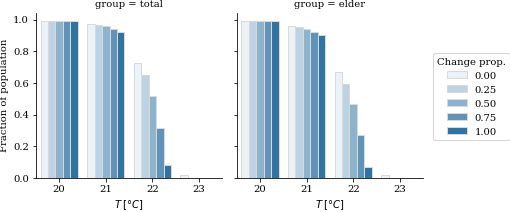

In [10]:
g = sns.FacetGrid(data=df, col='group')
g.map_dataframe(sns.barplot, x='T', y='count', hue='change_prop')
g.set_axis_labels(x_var='$T \; [\\degree C]$', y_var='Fraction of population')
g.add_legend(title='Change prop.', bbox_to_anchor=(1.02, .5), frameon=True)
# for ax in g.axes.flat:
#     ax.ticklabel_format(axis='y',
#                         style='sci',
#                         scilimits=(3, 3),
#                         useOffset=True)
g.fig.savefig('../reports/figures/human-exposure.pdf')